22H1120016 - Trần Đăng Nam

Thực hiện trên dữ liệu breast - cancer

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report, make_scorer
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree


In [24]:
bc = load_breast_cancer()

# Create a pandas DataFrame for easier manipulation later (optional but helpful)
df = pd.DataFrame(bc.data, columns=bc.feature_names)
df['target'] = bc.target
df['target_name'] = df['target'].map({0: bc.target_names[0], 1: bc.target_names[1]})

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(bc.data, bc.target,
                                                   test_size=0.3,
                                                   train_size=0.7,
                                                   random_state=43,
                                                   stratify =  bc.target)

# --- Standardize Features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
# Define parameter grid for grid search
param_grid = {
    'max_depth': [None, 2, 3, 4, 5, 6, 7, 8],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Create F1 scorer for multiclass classification
f1_scorer = make_scorer(f1_score, average='macro')

# Create the grid search with cross-validation
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=43),
    param_grid=param_grid,
    scoring=f1_scorer,
    cv=17,              # 15-fold cross-validation for training 
    n_jobs=-1
)

# Fit the grid search to the data
grid_search.fit(X_train_scaled, y_train)

# Get best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best F1 Score (CV): {best_score:.4f}")

Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best F1 Score (CV): 0.9434


In [26]:
# Train the final model with the best parameters
best_dt = DecisionTreeClassifier(random_state=100, **best_params)
best_dt.fit(X_train_scaled, y_train)

# Evaluate on the test set
y_pred = best_dt.predict(X_test_scaled)
test_f1 = f1_score(y_test, y_pred, average='macro')
test_accuracy = accuracy_score(y_test, y_pred)

print(f"\nTest F1 Score: {test_f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=bc.target_names))


# --- Train Final Model ---
best_dt = DecisionTreeClassifier(random_state=100, **best_params)
best_dt.fit(X_train_scaled, y_train)



Test F1 Score: 0.9246
Test Accuracy: 0.9298

Classification Report:
              precision    recall  f1-score   support

   malignant       0.92      0.89      0.90        64
      benign       0.94      0.95      0.94       107

    accuracy                           0.93       171
   macro avg       0.93      0.92      0.92       171
weighted avg       0.93      0.93      0.93       171



DecisionTreeClassifier(criterion='entropy', random_state=100)


Confusion Matrix:
[[ 57   7]
 [  5 102]]


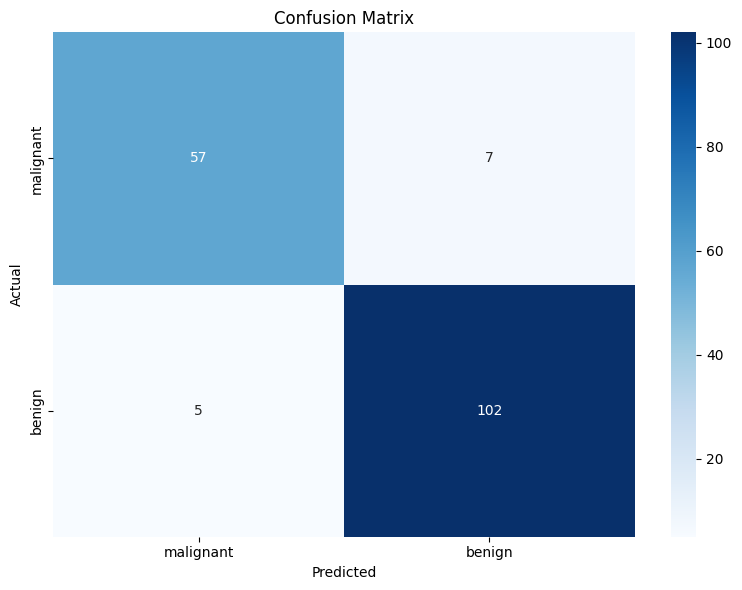

In [30]:
# --- Visualization 1: Confusion Matrix ---
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=bc.target_names, yticklabels=bc.target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

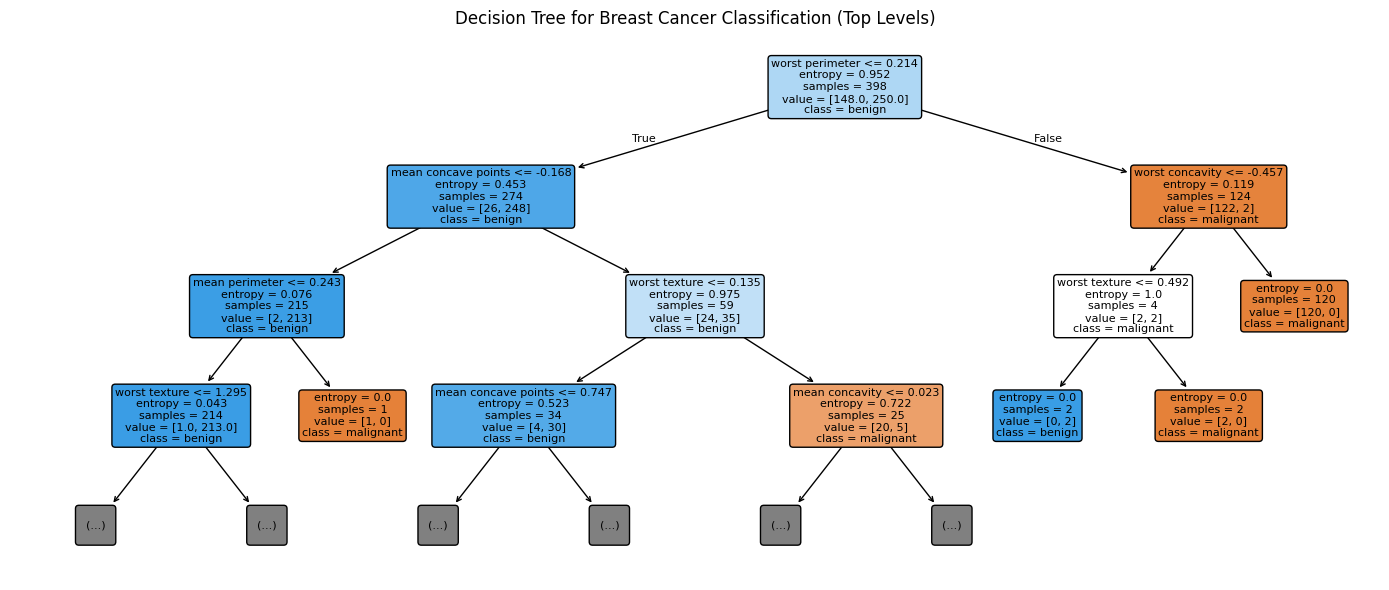

In [37]:
# --- Visualization 2: Decision Tree Plot ---
plt.figure(figsize=(14, 6)) # Increased size slightly
plot_tree(
    best_dt,
    filled=True,
    feature_names=bc.feature_names,
    class_names=bc.target_names,
    fontsize=8,
    max_depth=3, # Keep max_depth for readability, shows top splits
    proportion=False,
    rounded=True # round cell 
)
# Corrected title
plt.title('Decision Tree for Breast Cancer Classification (Top Levels)')
plt.tight_layout()
plt.show()


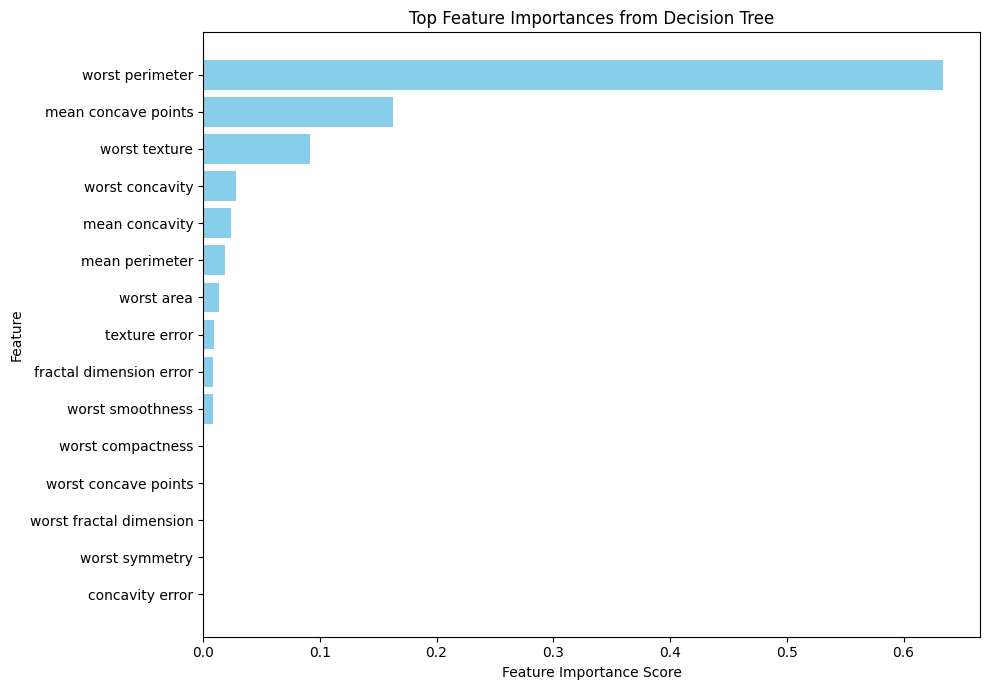

In [38]:
# --- Visualization 3: Feature Importance ---
importances = best_dt.feature_importances_
indices = np.argsort(importances)[::-1] # Sort features by importance
num_features_to_plot = 15 # Show top 15 features

plt.figure(figsize=(10, 7))
plt.title("Top Feature Importances from Decision Tree")
plt.barh(range(num_features_to_plot), importances[indices[:num_features_to_plot]],
       color="skyblue", align="center")
plt.yticks(range(num_features_to_plot), [bc.feature_names[i] for i in indices[:num_features_to_plot]])
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.gca().invert_yaxis() # Display the most important feature at the top
plt.tight_layout()
plt.show()


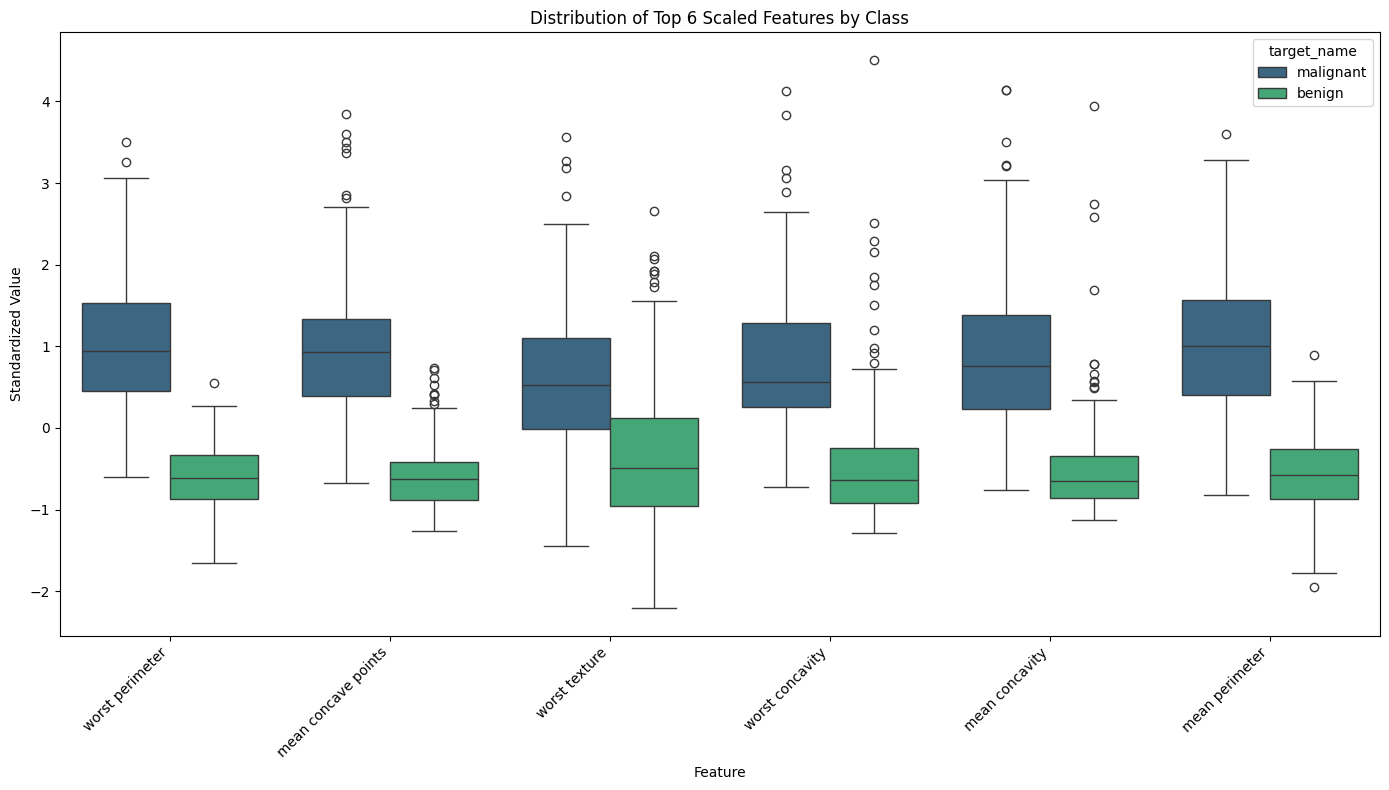

In [40]:
# --- Visualization 4: Box Plots of Key Features by Class ---

# Use the top N features from the importance plot
top_n_features = 6 # Let's plot the top 6
top_feature_indices = indices[:top_n_features]
top_feature_names = [bc.feature_names[i] for i in top_feature_indices]

# Create a DataFrame with scaled training data and target for easier plotting
df_train_scaled = pd.DataFrame(X_train_scaled, columns=bc.feature_names)
df_train_scaled['target'] = y_train
df_train_scaled['target_name'] = df_train_scaled['target'].map({0: bc.target_names[0], 1: bc.target_names[1]})

# Melt the DataFrame for Seaborn boxplot
df_melt = pd.melt(df_train_scaled,
                  id_vars=['target', 'target_name'],
                  value_vars=top_feature_names,
                  var_name='Feature',
                  value_name='Standardized Value')

plt.figure(figsize=(14, 8))
sns.boxplot(x='Feature', y='Standardized Value', hue='target_name', data=df_melt, palette='viridis')
plt.title(f'Distribution of Top {top_n_features} Scaled Features by Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




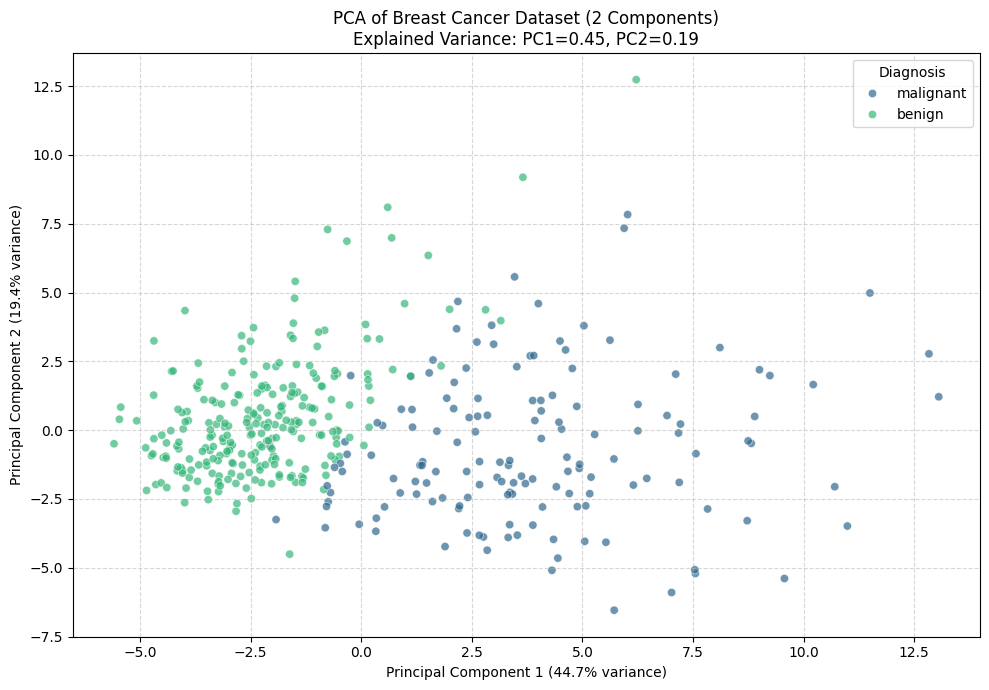

In [41]:
# --- Visualization 5: PCA Scatter Plot (2D) ---

# Apply PCA on the scaled training data
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

# Create a DataFrame for plotting PCA results
pca_df = pd.DataFrame(data=X_train_pca, columns=['Principal Component 1', 'Principal Component 2'])
pca_df['target'] = y_train
pca_df['target_name'] = pca_df['target'].map({0: bc.target_names[0], 1: bc.target_names[1]})

# Calculate explained variance
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="Principal Component 1", y="Principal Component 2",
    hue="target_name",
    palette="viridis", # Use the same palette for consistency
    data=pca_df,
    alpha=0.7 # Add transparency
)
plt.title(f'PCA of Breast Cancer Dataset (2 Components)\nExplained Variance: PC1={explained_variance[0]:.2f}, PC2={explained_variance[1]:.2f}')
plt.xlabel(f'Principal Component 1 ({explained_variance[0]*100:.1f}% variance)')
plt.ylabel(f'Principal Component 2 ({explained_variance[1]*100:.1f}% variance)')
plt.legend(title='Diagnosis')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()